In [0]:
# Load necessary packages
import numpy as np
import pandas as pd
import matplotlib as mpl
from plotnine import *

# Visualization modules
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data-processing modules 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Modeling and evaluation modules 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

# Module for saving model
import pickle 

# Set seed for reproducibility 
SEED = 42

In [0]:
# Set up shared drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Load dataset 
datapath = '/content/drive/Shared drives/Machine Learning/Code/data/financial_data.csv'
data = pd.read_csv(datapath)

In [0]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [0]:
# Renaming columns for consistency
data = data.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig',
                            'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [0]:
# Get dimension of data 
data.shape

(6362620, 11)

In [0]:
# Check data info 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldBalanceOrig  float64
 5   newBalanceOrig  float64
 6   nameDest        object 
 7   oldBalanceDest  float64
 8   newBalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [0]:
# Check if we have null values 
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldBalanceOrig    0
newBalanceOrig    0
nameDest          0
oldBalanceDest    0
newBalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [0]:
# Get statistics from the data 
data.describe()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Understanding each column of the dataset 

In [0]:
# How many hours of data we have 
data.step.nunique()

743

In [0]:
# See the different types of transactions included 
data.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [0]:
# Check the number of customers who started the transaction - nameOrig documents the ID of customers who started the transaction 
data.nameOrig.nunique()

6353307

In [0]:
# Check the number of recipients - nameDest documents the ID of transaction recipients  
data.nameDest.nunique()

2722362

Fraudulent Transactions

In [0]:
# Check how many fraudulent transactions there are in our data
data.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

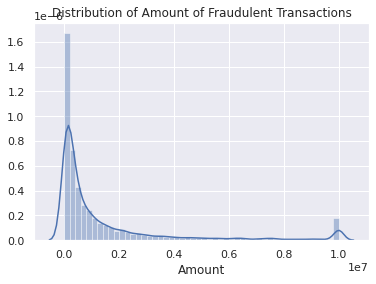

In [0]:
# Distribution of amount of flagged transactions 
sns.distplot(data.loc[data.isFraud == 1].amount)
plt.xlabel('Amount')
plt.title('Distribution of Amount of Fraudulent Transactions')
plt.show()



In [0]:
# Min amount of flagged transactions
data.loc[data.isFraud == 1].amount.min()

0.0

In [0]:
# Mean amount of flagged transactions
data.loc[data.isFlaggedFraud == 1].amount.mean()

4861597.730625

In [0]:
# Max amount of flagged transactions
data.loc[data.isFraud == 1].amount.max()

10000000.0

Transactions Flagged as Fraud 

In [0]:
# Check how many transactions are flagged fraud 
data.isFlaggedFraud.value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [0]:
# All the transactions flagged fraud are of the type "transfer"
flagged_by_type = data.loc[data.isFlaggedFraud == 1].groupby("type").size()
flagged_by_type

type
TRANSFER    16
dtype: int64

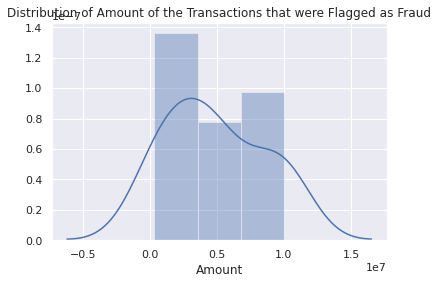

In [0]:
# Distribution of amount of flagged transactions 
sns.distplot(data.loc[data.isFlaggedFraud == 1].amount)
plt.xlabel('Amount')
plt.title('Distribution of Amount of the Transactions that were Flagged as Fraud')
plt.show()

In [0]:
# Min amount of flagged transactions
data.loc[data.isFlaggedFraud == 1].amount.min()

353874.22

In [0]:
# Max amount of flagged transactions 
data.loc[data.isFlaggedFraud == 1].amount.max()

10000000.0

Transaction count by types of transactions 

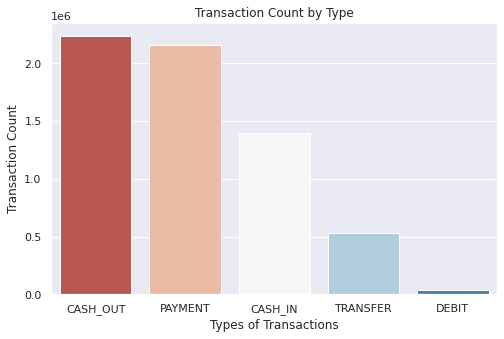

In [0]:
transaction_by_type = data.groupby("type").size().reset_index(name="transaction_count")\
    .sort_values("transaction_count", ascending = False)

fig, ax = plt.subplots(figsize=(8,5))
_ = sns.barplot(x="type", y="transaction_count", data=transaction_by_type,
                palette='RdBu', ax=ax)
_ = ax.set(xlabel="Types of Transactions", ylabel="Transaction Count", 
           title = 'Transaction Count by Type')

Fraudulent Transaction Count by Type

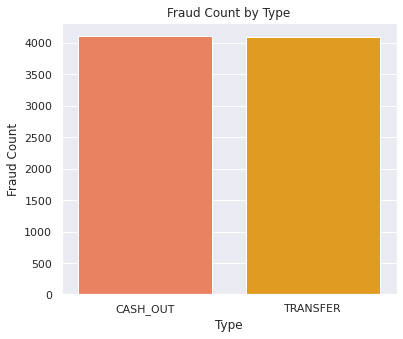

In [0]:
fraud_by_type = data.loc[data.isFraud == 1].groupby("type").size().reset_index(name="fraud_count")\
    .sort_values("fraud_count", ascending = False)

fig, ax = plt.subplots(figsize=(6,5))
_ = sns.barplot(x="type", y="fraud_count", data=fraud_by_type, 
                palette=sns.color_palette(['#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Type", ylabel="Fraud Count", title = "Fraud Count by Type")


Distribution of Transaction over Time 

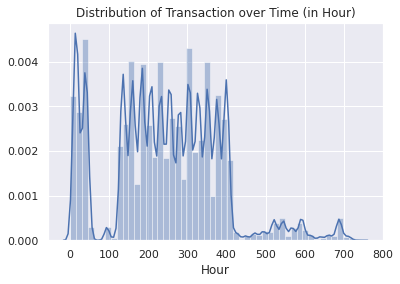

In [0]:
sns.distplot(data.step)
plt.xlabel('Hour')
plt.title('Distribution of Transaction over Time (in Hour)')
plt.show()

In [0]:
# Do any of the transaction origninator ID belong to a merchant? 
data.nameOrig.str.contains('M').any()

False

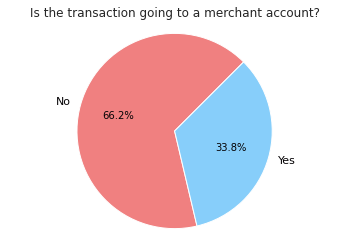

In [0]:
# What percentage of the transactions are going towards a merchant account? 
value_counts = data.nameDest.str.contains('M').value_counts().to_dict()

fig, ax = plt.subplots()
_ = ax.pie([value_counts[False], value_counts[True]], labels=['No', 'Yes'], 
           colors=['lightcoral', 'lightskyblue'], textprops={'color': '#040204'}, autopct='%1.1f%%', startangle=45)
_ = ax.axis('equal')
_ = ax.set_title('Is the transaction going to a merchant account?')

In [0]:
# Assume step 1 means the first hour of the first day of simulation, and step 744 last hour of simulation
day = (data.step // 24) %7
hour = data.step % 24

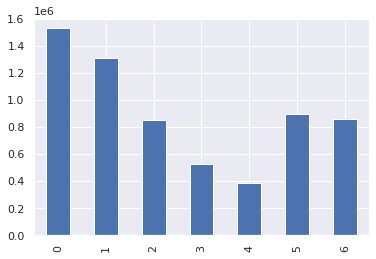

In [0]:
#day distribution plot
day.value_counts().sort_index().plot(kind='bar');

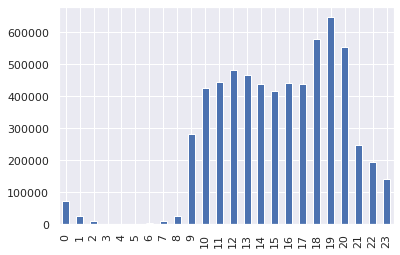

In [0]:
# hour distribution plot
hour.value_counts().sort_index().plot(kind='bar');

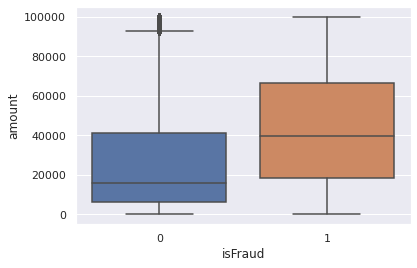

In [0]:
sns.boxplot(x = 'isFraud', y = 'amount', data = data[data.amount < 100000]);

# Conclusion - we can see that the amount transfered is higher on average on fraudulent transactions

C    4211125
M    2151495
Name: nameDest, dtype: int64


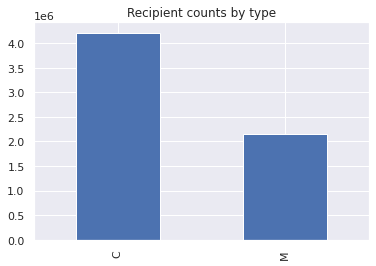

In [0]:
#Explore nameDest counts (the recipient of the transaction M/C)

print(data.nameDest.str[0].value_counts())
data.nameDest.str[0].value_counts().plot(kind='bar', title = 'Recipient counts by type');

# Conclusion - fairly distributed among classes